# 5 — 2D Reaction–Diffusion (Ocean Map): Single Species

We extend the 1D reaction–diffusion model to a **2D ocean map**:

- $x \in [0, L_x]$ — **alongshore** coordinate (periodic BC: fish can migrate continuously around the coast)  
- $y \in [0, L_y]$ — **offshore** distance from coast (Neumann no-flux BC at both ends)

The dimensional PDE is:

$$
\frac{\partial u}{\partial t} = r\,u\!\left(1 - \frac{u}{K}\right) - h(y,t)\,u \;+\; D\!\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)
$$

**Boundary conditions:**
- $x$: periodic — `np.roll` stencil
- $y = 0, L_y$: Neumann no-flux — ghost-point via `np.pad(mode='reflect')`

**EEZ boundary:** $y_{\text{bnd}} = 200$ miles offshore.

$$
h(y,t) = \begin{cases} h_{\text{in}} & y \le y_{\text{bnd}} \\ h_{\text{out}} & y > y_{\text{bnd}} \end{cases}
\quad \text{(optionally pulsed in time)}
$$

**Grid:** $n_x = n_y = 200$, $\Delta x = \Delta y = 3.0$ miles $\Rightarrow L_x = L_y = 597$ miles, EEZ row $\approx 66$.

**Numerics:** explicit Euler, $\Delta t = 0.2\,\min(\Delta x^2,\Delta y^2)\,/\,(4D)$.

---

### Scenarios

| Label | $h_{\text{in}}$ | $h_{\text{out}}$ | Description |
|-------|----------------|-----------------|-------------|
| A0 | 0 | 0 | No fishing (baseline) |
| A1 | 0.2 | 0.2 | Uniform fishing |
| A2 | 0.0 | 0.2 | EEZ protected, offshore fished |
| A3 | 0.0 | 0.2 | A2 + offshore pulse $h=0.5$ for $t \in [20, 30]$ |

In [10]:
import numpy as np
from matplotlib import pyplot as plt

# ═══════════════════════════════════════════════════════════════════════
# §5 HELPER FUNCTIONS  (self-contained — no external modules)
# ═══════════════════════════════════════════════════════════════════════

def laplacian_2d_periodicx_neumanny(U, dx, dy):
    """2D Laplacian: periodic in x (axis=1), Neumann no-flux in y (axis=0).

    Ghost-point approach for y:
      np.pad with mode='reflect' on axis 0 gives:
        padded[0,:]      = U[1,:]    <- ghost above row 0   => du/dy=0 at y=0
        padded[ny+1, :]  = U[ny-2,:] <- ghost below row ny-1 => du/dy=0 at y=Ly
    This is the standard second-order Neumann finite difference.

    Parameters
    ----------
    U  : ndarray shape (ny, nx)
    dx : float  grid spacing in x (miles)
    dy : float  grid spacing in y (miles)

    Returns
    -------
    lap : ndarray shape (ny, nx)
    """
    # ── x-direction: periodic ─────────────────────────────────────────
    d2U_dx2 = (np.roll(U, 1, axis=1) - 2.0 * U + np.roll(U, -1, axis=1)) / dx**2

    # ── y-direction: Neumann via reflect pad ──────────────────────────
    # padded shape: (ny+2, nx)
    U_pad = np.pad(U, ((1, 1), (0, 0)), mode='reflect')
    # U_pad[0:ny]    = up-neighbors  (U_pad[0,:] = U[1,:] at boundary)
    # U_pad[2:ny+2]  = down-neighbors (U_pad[ny+1,:] = U[ny-2,:] at boundary)
    d2U_dy2 = (U_pad[:-2, :] - 2.0 * U + U_pad[2:, :]) / dy**2

    return d2U_dx2 + d2U_dy2


def fishing_profile_y(y_grid, t, y_boundary, h_in, h_out, pulse=None):
    """Return fishing rate array of shape (ny,) for the given time t.

    Parameters
    ----------
    y_grid     : 1-D array (ny,)  y-coordinate of each row (miles)
    t          : float            current simulation time
    y_boundary : float            EEZ boundary (miles)
    h_in       : float            harvest rate inside EEZ  (y <= y_boundary)
    h_out      : float            harvest rate outside EEZ (y >  y_boundary)
    pulse      : dict or None     optional offshore pulse with keys
                                  't_start', 't_end', 'h_out_pulse'

    Returns
    -------
    h_y : ndarray (ny,)   — reshape to (ny,1) before multiplying (ny,nx) field
    """
    h_y = np.where(y_grid <= y_boundary, h_in, h_out)
    if pulse is not None:
        if pulse['t_start'] <= t <= pulse['t_end']:
            h_y = np.where(y_grid <= y_boundary, h_in, pulse['h_out_pulse'])
    return h_y


def simulate_2d_single(r, K, D, nx, ny, dx, dy, T_end,
                       snapshot_times, y_boundary,
                       h_in=0.0, h_out=0.0, pulse=None, seed=42,
                       cx0=None, cy0=None, ic_sigma=40.0):
    """Explicit-Euler 2D single-species logistic + diffusion with EEZ fishing.

    PDE:  u_t = r*u*(1-u/K) - h(y,t)*u + D*(u_xx + u_yy)
    BC:   periodic in x,  Neumann no-flux in y

    Parameters
    ----------
    r, K, D         : float   growth rate, carrying capacity, diffusivity
    nx, ny          : int     grid dimensions
    dx, dy          : float   grid spacing (miles)
    T_end           : float   total simulation time
    snapshot_times  : list    times at which to save U snapshot
    y_boundary      : float   EEZ boundary y-coordinate (miles)
    h_in, h_out     : float   harvest rates inside / outside EEZ
    pulse           : dict or None  optional pulse dict for offshore fishing
    seed            : int     random seed for reproducibility
    cx0, cy0        : float or None  x,y centre of initial Gaussian (miles);
                                     defaults to domain centre if None
    ic_sigma        : float   standard deviation of initial Gaussian (miles)

    Returns
    -------
    dict with keys:
        'x_grid', 'y_grid'    : coordinate arrays
        'snapshots'           : dict {t_float -> ndarray (ny, nx)}
        'time', 'Btot'        : time series of total biomass
        'Bin', 'Bout'         : biomass inside / outside EEZ
        'y_bnd_row'           : row index of EEZ boundary
        'dt'                  : actual time step used
    """
    np.random.seed(seed)

    # ── Grid ──────────────────────────────────────────────────────────
    x_grid = np.linspace(0.0, (nx - 1) * dx, nx)   # (nx,)
    y_grid = np.linspace(0.0, (ny - 1) * dy, ny)   # (ny,)
    XX, YY = np.meshgrid(x_grid, y_grid)            # both (ny, nx)

    y_bnd_row = int(np.searchsorted(y_grid, y_boundary, side='right')) - 1

    # ── Time step (diffusion CFL + safety factor 0.2) ─────────────────
    dt = 0.2 * min(dx**2, dy**2) / (4.0 * D)
    nt = int(np.ceil(T_end / dt))
    dt = T_end / nt          # adjust so last step lands exactly on T_end

    # ── Initial condition ─────────────────────────────────────────────
    # Fish start concentrated at (_cx, _cy) and disperse via diffusion
    _cx = cx0 if cx0 is not None else 0.5 * (nx - 1) * dx
    _cy = cy0 if cy0 is not None else 0.5 * (ny - 1) * dy
    U = K * np.exp(-((XX - _cx)**2 + (YY - _cy)**2) / (2.0 * ic_sigma**2))
    U = np.maximum(U, 0.0)

    # ── Snapshot setup ────────────────────────────────────────────────
    snap_set = sorted(snapshot_times)
    snap_idx = 0
    snapshots = {}
    if snap_idx < len(snap_set) and snap_set[snap_idx] <= 0.0 + 1e-12:
        snapshots[snap_set[snap_idx]] = U.copy()
        snap_idx += 1

    # ── Biomass diagnostics ───────────────────────────────────────────
    def _btot(F, y_vals=None):
        y_use = y_grid if y_vals is None else y_vals
        return np.trapezoid(np.trapezoid(F, x_grid, axis=1), y_use)

    time_arr = np.empty(nt + 1);  Btot = np.empty(nt + 1)
    Bin      = np.empty(nt + 1);  Bout = np.empty(nt + 1)
    time_arr[0] = 0.0
    Btot[0] = _btot(U)
    Bin[0]  = _btot(U[:y_bnd_row + 1, :], y_grid[:y_bnd_row + 1])
    Bout[0] = _btot(U[y_bnd_row:, :], y_grid[y_bnd_row:])

    # ── Time loop ─────────────────────────────────────────────────────
    for n in range(1, nt + 1):
        t_now = n * dt

        # Fishing: shape (ny,) -> (ny,1) for broadcasting over (ny,nx)
        h_y = fishing_profile_y(y_grid, t_now - 0.5 * dt,
                                y_boundary, h_in, h_out, pulse)
        h_2d = h_y[:, np.newaxis]   # CRITICAL: must be (ny,1) not (ny,)

        lap = laplacian_2d_periodicx_neumanny(U, dx, dy)
        dU  = r * U * (1.0 - U / K) - h_2d * U + D * lap
        U   = np.maximum(U + dt * dU, 0.0)

        # Diagnostics
        time_arr[n] = t_now
        Btot[n] = _btot(U)
        Bin[n]  = _btot(U[:y_bnd_row + 1, :], y_grid[:y_bnd_row + 1])
        Bout[n] = _btot(U[y_bnd_row:, :], y_grid[y_bnd_row:])

        # Snapshot capture
        while snap_idx < len(snap_set) and t_now >= snap_set[snap_idx] - 0.5 * dt:
            snapshots[snap_set[snap_idx]] = U.copy()
            snap_idx += 1

    return {
        'x_grid': x_grid, 'y_grid': y_grid,
        'snapshots': snapshots,
        'time': time_arr, 'Btot': Btot, 'Bin': Bin, 'Bout': Bout,
        'y_bnd_row': y_bnd_row, 'dt': dt,
    }


print('§5 helper functions defined: laplacian_2d_periodicx_neumanny, '
      'fishing_profile_y, simulate_2d_single')

§5 helper functions defined: laplacian_2d_periodicx_neumanny, fishing_profile_y, simulate_2d_single


In [11]:
# ── §5 Grid & physical parameters ────────────────────────────────────
nx_5: int   = 200;   ny_5: int   = 200
dx_5: float = 3.0;   dy_5: float = 3.0     # miles per cell
Lx_5: float = (nx_5 - 1) * dx_5            # 597 miles
Ly_5: float = (ny_5 - 1) * dy_5

r_5:  float = 0.3    # yr⁻¹
K_5:  float = 1.0    # carrying capacity (normalised)
D_5:  float = 5.0    # miles² yr⁻¹
T_end_5:     float = 60.0
Y_BND_5:     float = 200.0    # 200-mile EEZ boundary
SNAP_TIMES_5 = [0.0, 10.0, 20.0, 40.0, 60.0]

# ── Stability printout ────────────────────────────────────────────────
dt_5_cfl = 0.2 * min(dx_5**2, dy_5**2) / (4.0 * D_5)
nt_5_est  = int(np.ceil(T_end_5 / dt_5_cfl))
y_grid_5_tmp = np.linspace(0.0, Ly_5, ny_5)
y_bnd_row_5  = int(np.searchsorted(y_grid_5_tmp, Y_BND_5, side='right')) - 1
print(f'Domain:      Lx = {Lx_5:.1f} miles,  Ly = {Ly_5:.1f} miles')
print(f'Grid cells:  nx = {nx_5},  ny = {ny_5},  dx = dy = {dx_5} miles')
print(f'EEZ row:     index {y_bnd_row_5}  '
      f'(y[{y_bnd_row_5}] = {y_grid_5_tmp[y_bnd_row_5]:.1f} miles)')
print(f'CFL dt:      {dt_5_cfl:.4f} yr  (~{nt_5_est} steps for T_end={T_end_5})')

# ── Scenario definitions ──────────────────────────────────────────────
SCENARIOS_5 = {
    'A0': dict(
        label    = 'No fishing (baseline)',
        h_in     = 0.0,
        h_out    = 0.0,
        pulse    = None,
    ),
    'A1': dict(
        label    = 'Uniform fishing  h = 0.2',
        h_in     = 0.2,
        h_out    = 0.2,
        pulse    = None,
    ),
    'A2': dict(
        label    = 'EEZ protected,  offshore h = 0.2',
        h_in     = 0.0,
        h_out    = 0.2,
        pulse    = None,
    ),
    'A3': dict(
        label    = 'EEZ protected + offshore pulse  h = 0.5 at t ∈ [20, 30]',
        h_in     = 0.0,
        h_out    = 0.2,
        pulse    = dict(t_start=20.0, t_end=30.0, h_out_pulse=0.5),
    ),
}

print(f'\nScenarios defined: {list(SCENARIOS_5.keys())}')

Domain:      Lx = 597.0 miles,  Ly = 597.0 miles
Grid cells:  nx = 200,  ny = 200,  dx = dy = 3.0 miles
EEZ row:     index 66  (y[66] = 198.0 miles)
CFL dt:      0.0900 yr  (~667 steps for T_end=60.0)

Scenarios defined: ['A0', 'A1', 'A2', 'A3']


In [12]:
# ── §5 Run all scenarios ──────────────────────────────────────────────
results_5 = {}
for key, scen in SCENARIOS_5.items():
    print(f'Running §5 scenario {key}: {scen["label"]} ...', end='  ', flush=True)
    res = simulate_2d_single(
        r           = r_5,
        K           = K_5,
        D           = D_5,
        nx          = nx_5,
        ny          = ny_5,
        dx          = dx_5,
        dy          = dy_5,
        T_end       = T_end_5,
        snapshot_times = SNAP_TIMES_5,
        y_boundary  = Y_BND_5,
        h_in        = scen['h_in'],
        h_out       = scen['h_out'],
        pulse       = scen['pulse'],
        seed        = 42,
    )
    results_5[key] = res
    print(f'done.  dt={res["dt"]:.5f} yr,  '
          f'Btot(t=0)={res["Btot"][0]:.2f},  '
          f'Btot(t={T_end_5:.0f})={res["Btot"][-1]:.2f}')

Running §5 scenario A0: No fishing (baseline) ...  

done.  dt=0.08996 yr,  Btot(t=0)=10053.10,  Btot(t=60)=232733.91
Running §5 scenario A1: Uniform fishing  h = 0.2 ...  done.  dt=0.08996 yr,  Btot(t=0)=10053.10,  Btot(t=60)=28837.04
Running §5 scenario A2: EEZ protected,  offshore h = 0.2 ...  done.  dt=0.08996 yr,  Btot(t=0)=10053.10,  Btot(t=60)=88426.98
Running §5 scenario A3: EEZ protected + offshore pulse  h = 0.5 at t ∈ [20, 30] ...  done.  dt=0.08996 yr,  Btot(t=0)=10053.10,  Btot(t=60)=75765.62


In [13]:
# ═══════════════════════════════════════════════════════════════════════
# §5 PLOTTING HELPERS
# ═══════════════════════════════════════════════════════════════════════

def plot_2d_snapshots_5(res, title, K, y_boundary, cmap='viridis'):
    """Heatmap grid: one panel per snapshot time.

    y=0 (coast) is at the bottom of each panel.
    Red dashed horizontal line marks the 200-mile EEZ boundary.
    """
    snap_times_sorted = sorted(res['snapshots'].keys())
    n = len(snap_times_sorted)
    x_grid = res['x_grid'];  y_grid = res['y_grid']

    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4.5),
                              sharey=True, constrained_layout=True)
    if n == 1:
        axes = [axes]

    vmin, vmax_c = 0.0, K * 1.1   # shared colour scale

    for ax, ts in zip(axes, snap_times_sorted):
        U = res['snapshots'][ts]
        pcm = ax.pcolormesh(x_grid, y_grid, U,
                            cmap=cmap, vmin=vmin, vmax=vmax_c,
                            shading='auto')
        # ── 200-mile EEZ line ──────────────────────────────────────
        ax.axhline(y_boundary, color='red', ls='--', lw=1.5,
                   label='200-mile EEZ')
        ax.set_title(f't = {ts:g} yr', fontsize=10)
        ax.set_xlabel('x  (along-shore, miles)')
        if ax is axes[0]:
            ax.set_ylabel('y  (offshore, miles)')
            ax.legend(fontsize=8, loc='upper right')
        fig.colorbar(pcm, ax=ax, label='density u')

    fig.suptitle(f'§5  {title}', fontsize=11, y=1.01)
    plt.show()


def plot_2d_biomass_5(res, title):
    """Biomass time series for §5: total, inside EEZ, outside EEZ."""
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(res['time'], res['Btot'], lw=2.0, color='steelblue',
            label='Total biomass')
    ax.plot(res['time'], res['Bin'],  lw=1.5, ls='--', color='seagreen',
            label='Inside EEZ')
    ax.plot(res['time'], res['Bout'], lw=1.5, ls=':',  color='tomato',
            label='Outside EEZ')
    ax.set_xlabel('Time  (yr)')
    ax.set_ylabel('Biomass  (miles² × density)')
    ax.set_title(f'§5 Biomass — {title}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()


print('§5 plot helpers defined: plot_2d_snapshots_5, plot_2d_biomass_5')

§5 plot helpers defined: plot_2d_snapshots_5, plot_2d_biomass_5


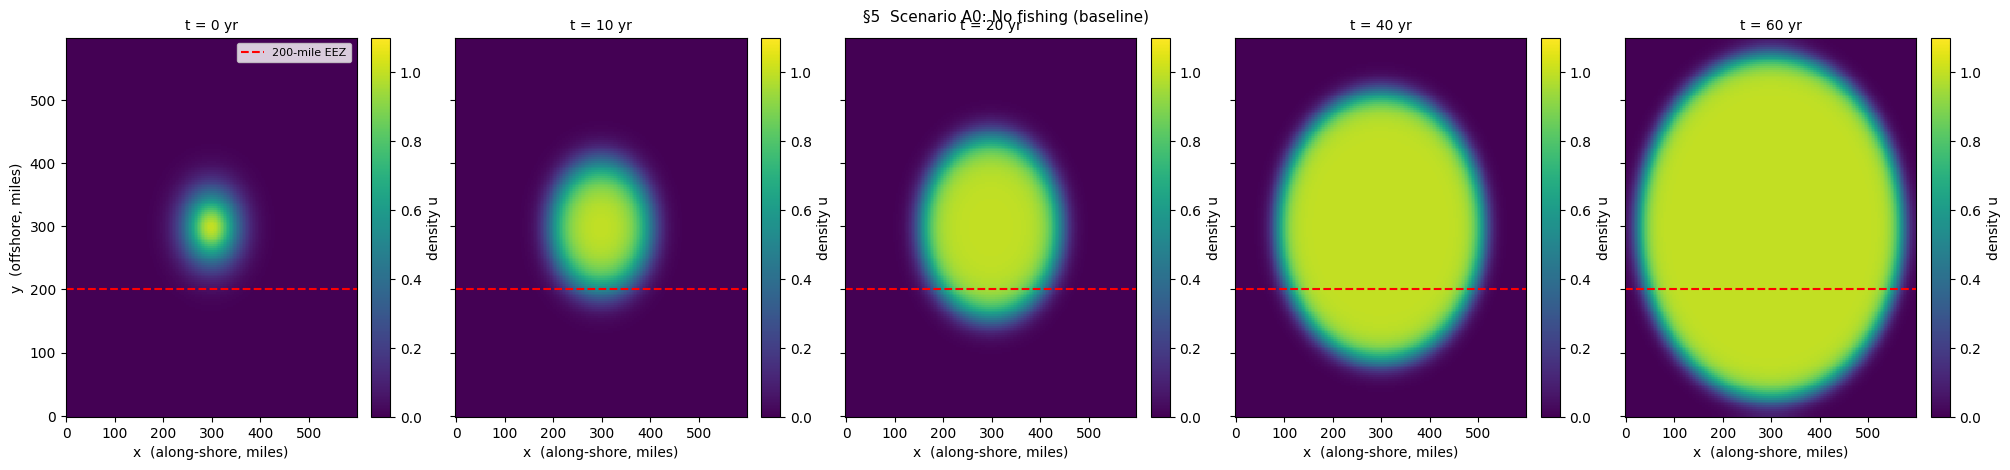

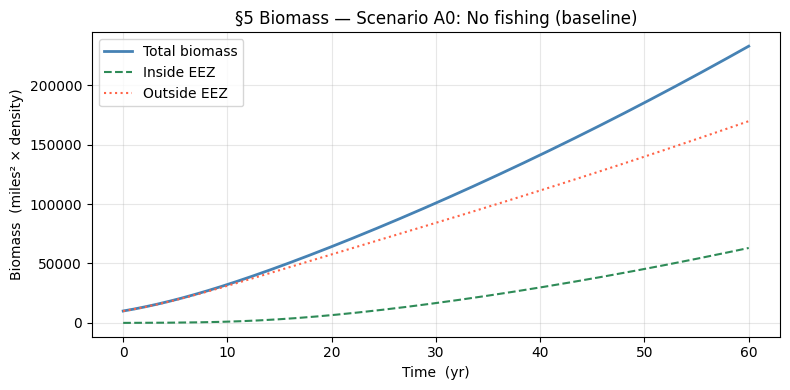

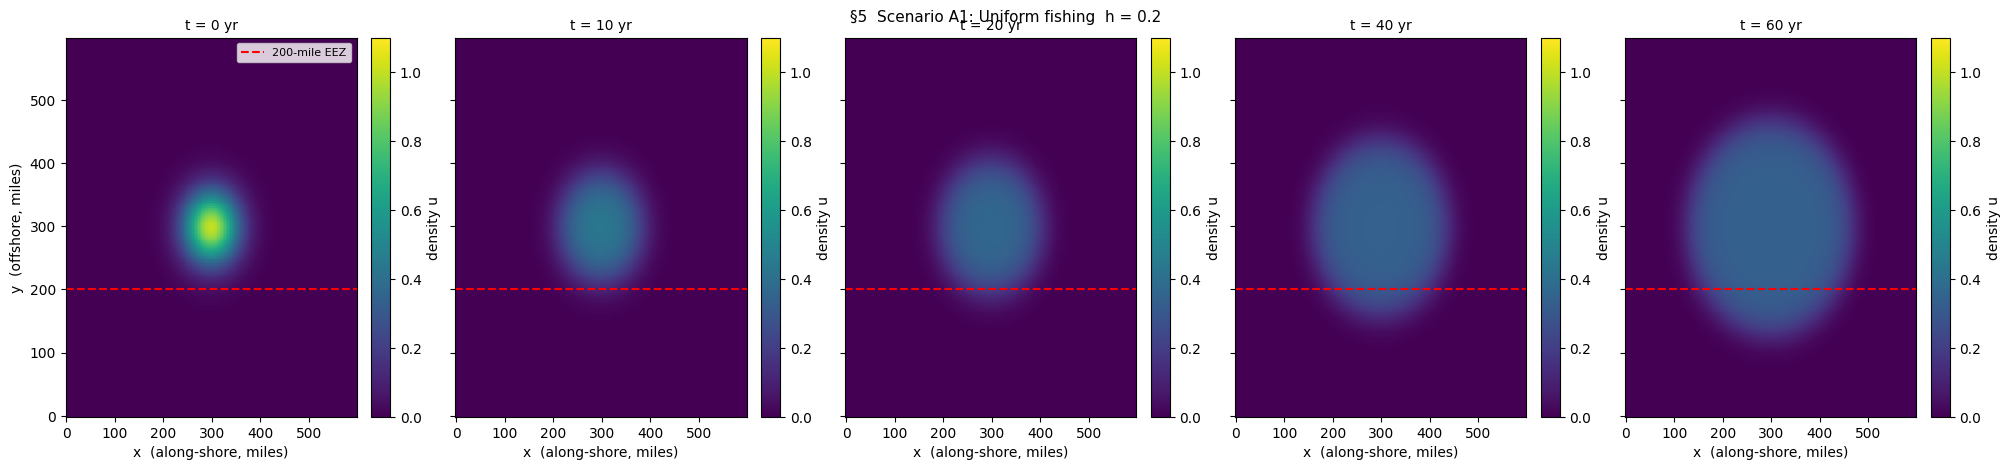

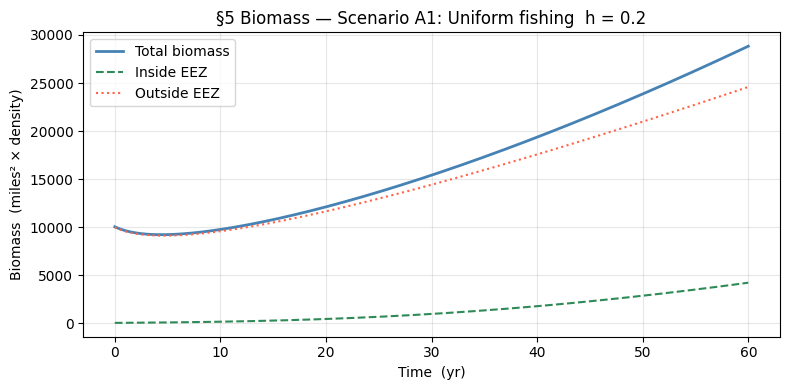

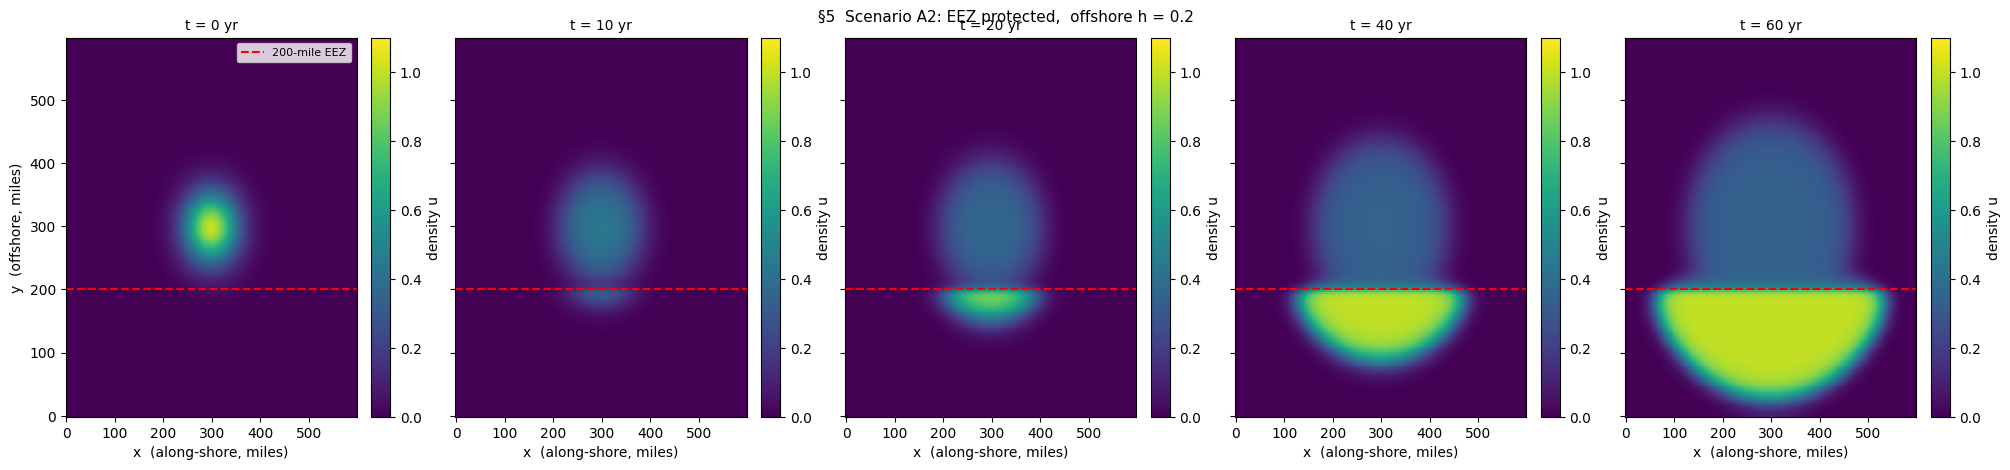

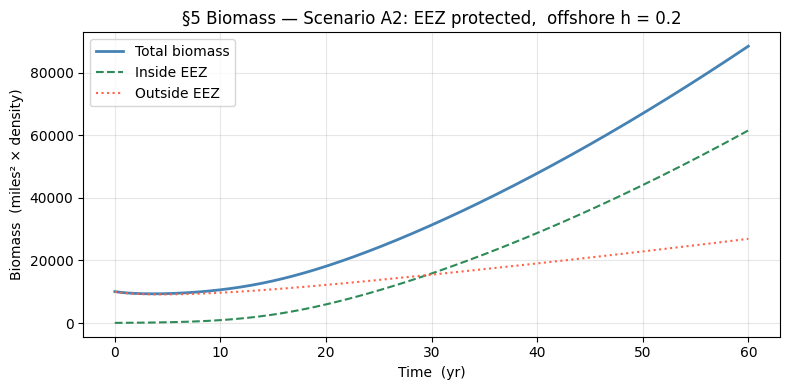

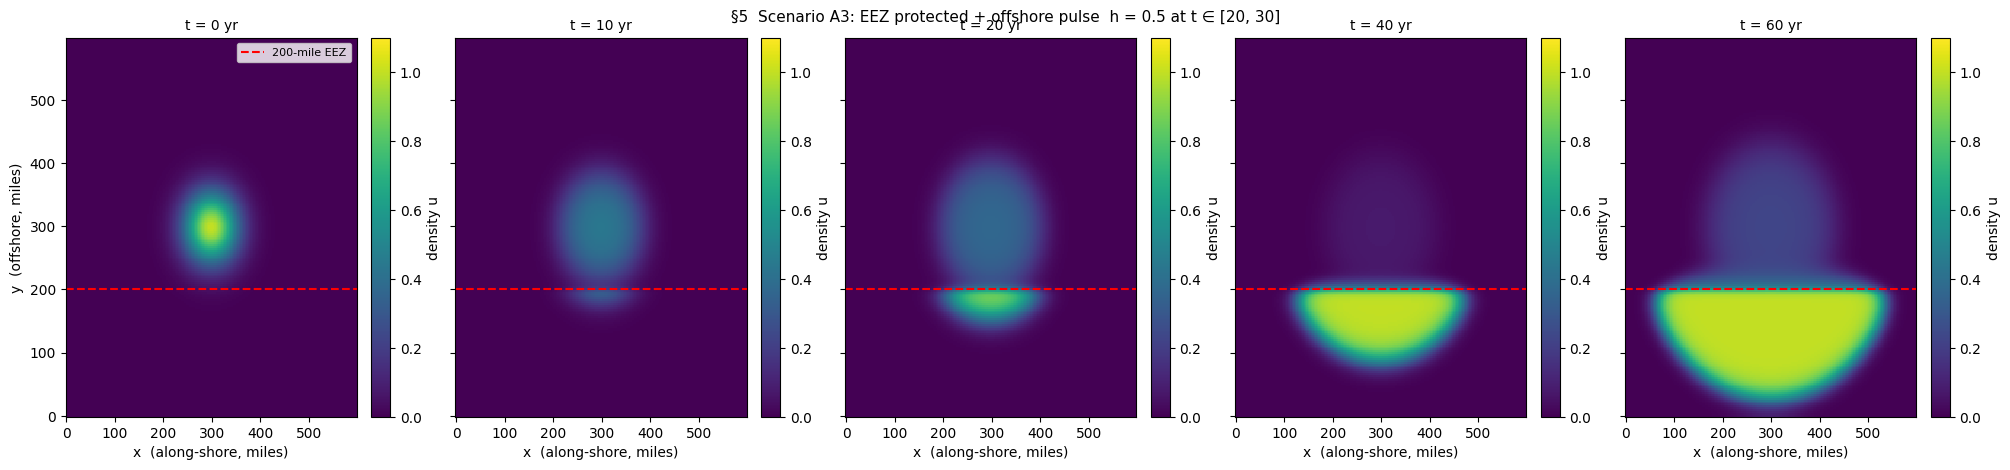

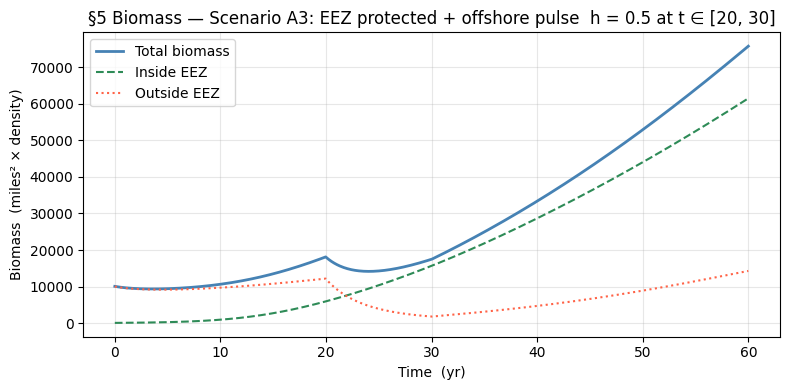

In [14]:
# ── §5 Plot all scenarios ─────────────────────────────────────────────
for key, scen in SCENARIOS_5.items():
    res   = results_5[key]
    title = f'Scenario {key}: {scen["label"]}'
    plot_2d_snapshots_5(res, title, K=K_5, y_boundary=Y_BND_5)
    plot_2d_biomass_5(res, title)

### §5 — Effect of Initial Position Relative to EEZ Boundary

All previous scenarios start the Gaussian blob at the domain centre (y ≈ 299 miles, outside EEZ).
Here we fix the fishing to **A2** (EEZ protected: $h_\text{in}=0$, $h_\text{out}=0.2$) and vary only
the **y-coordinate** of the initial fish concentration:

| Label | $c_{y_0}$ (miles) | Region |
|-------|-------------------|--------|
| IC_in | 100 | Inside EEZ (coastal) |
| IC_bnd | 200 | On the EEZ boundary |
| IC_out | 350 | Outside EEZ (offshore) |

$\sigma = 40$ miles, $c_{x_0} = 0.5\,L_x = 298.5$ miles for all three.

In [15]:
# ── §5 IC comparison: scenario definitions ──────────────────────────
# Fishing config fixed to A2 (EEZ protected: h_in=0, h_out=0.2)
_A2 = SCENARIOS_5['A2']

IC_SCENARIOS_5 = {
    'IC_in': dict(
        label = 'Start inside EEZ  (cy₀ = 100 mi)',
        cy0   = 100.0,
    ),
    'IC_bnd': dict(
        label = 'Start on boundary  (cy₀ = 200 mi)',
        cy0   = 200.0,
    ),
    'IC_out': dict(
        label = 'Start outside EEZ  (cy₀ = 350 mi)',
        cy0   = 350.0,
    ),
}
print(f'IC scenarios defined: {list(IC_SCENARIOS_5.keys())}')
print(f'  cy0 values (miles): { {k: v["cy0"] for k, v in IC_SCENARIOS_5.items()} }')
print(f'  EEZ boundary: {Y_BND_5} miles  |  domain Ly: {Ly_5} miles')

IC scenarios defined: ['IC_in', 'IC_bnd', 'IC_out']
  cy0 values (miles): {'IC_in': 100.0, 'IC_bnd': 200.0, 'IC_out': 350.0}
  EEZ boundary: 200.0 miles  |  domain Ly: 597.0 miles


In [16]:
# ── §5 IC comparison: run simulations ────────────────────────────────
results_5_ic = {}
for key, scen in IC_SCENARIOS_5.items():
    print(f'Running §5 IC scenario {key}: {scen["label"]} ...', end='  ', flush=True)
    res = simulate_2d_single(
        r=r_5, K=K_5, D=D_5,
        nx=nx_5, ny=ny_5, dx=dx_5, dy=dy_5,
        T_end=T_end_5,
        snapshot_times=SNAP_TIMES_5,
        y_boundary=Y_BND_5,
        h_in=_A2['h_in'], h_out=_A2['h_out'], pulse=_A2['pulse'],
        seed=42,
        cx0=0.5 * Lx_5,
        cy0=scen['cy0'],
        ic_sigma=40.0,
    )
    results_5_ic[key] = res
    print(f'done.  Btot(0)={res["Btot"][0]:.2f},  Btot({T_end_5:.0f})={res["Btot"][-1]:.2f}')

Running §5 IC scenario IC_in: Start inside EEZ  (cy₀ = 100 mi) ...  done.  Btot(0)=9990.46,  Btot(60)=112586.61
Running §5 IC scenario IC_bnd: Start on boundary  (cy₀ = 200 mi) ...  done.  Btot(0)=10053.09,  Btot(60)=113325.05
Running §5 IC scenario IC_out: Start outside EEZ  (cy₀ = 350 mi) ...  done.  Btot(0)=10053.10,  Btot(60)=65952.52


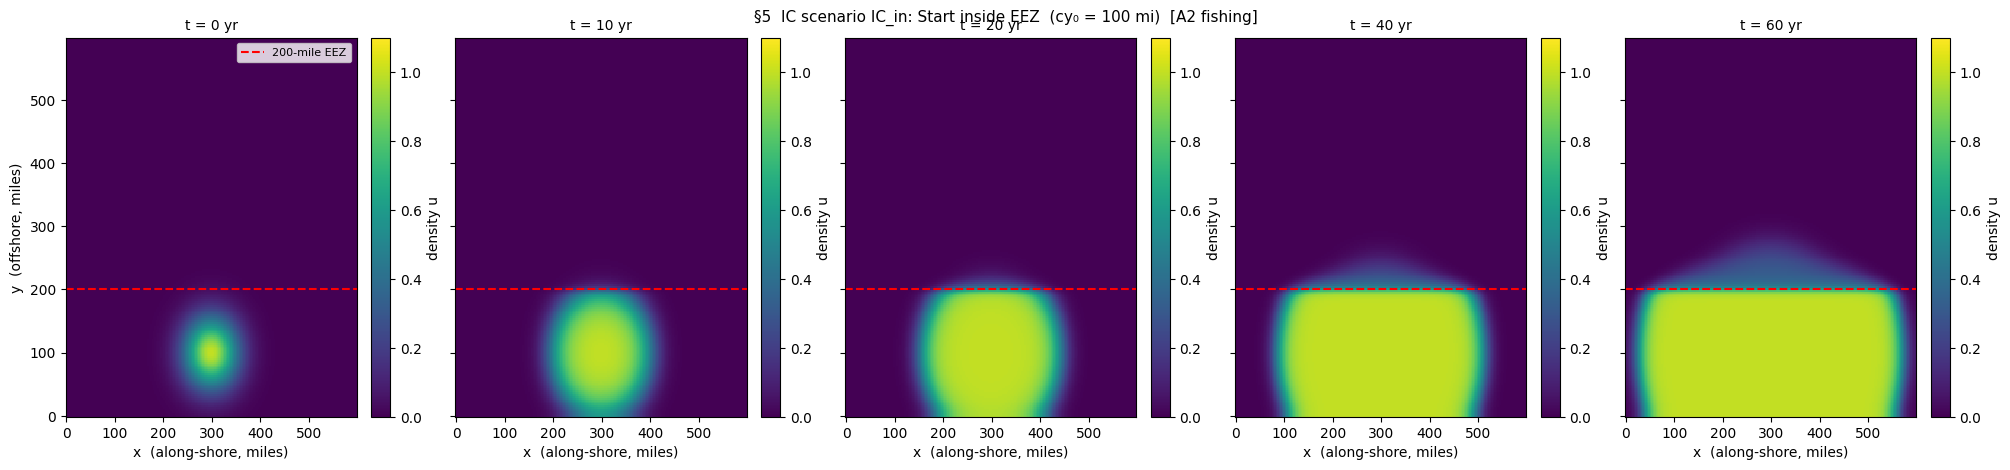

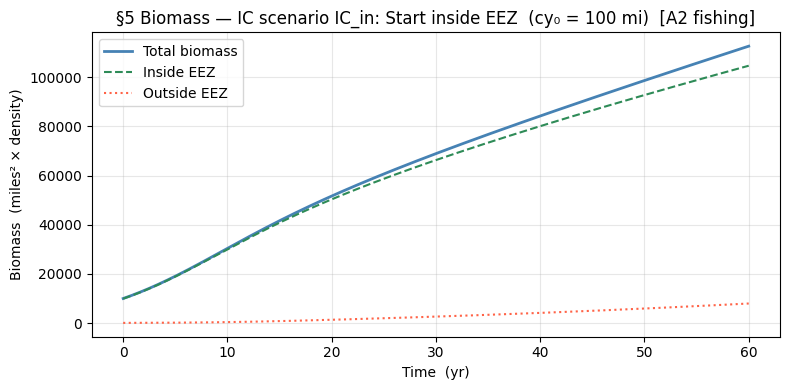

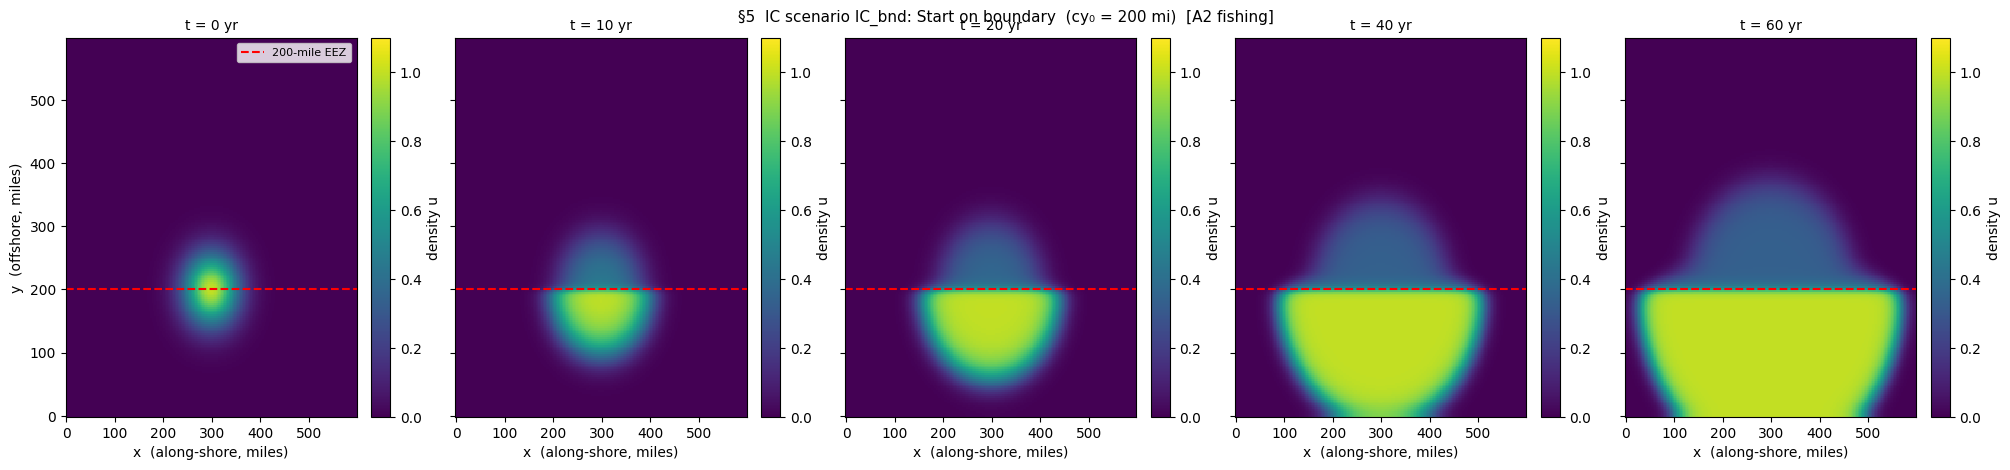

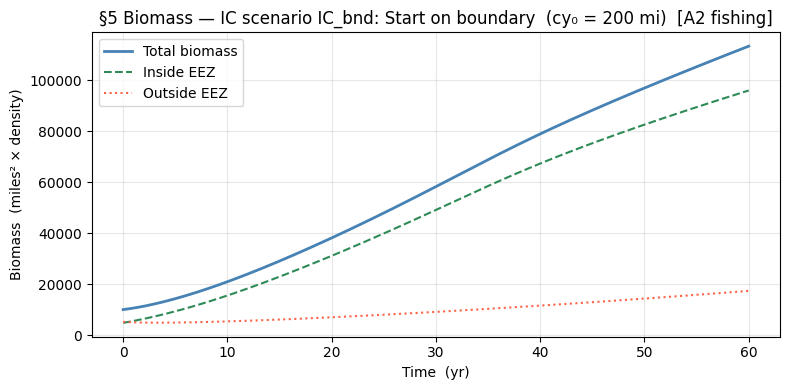

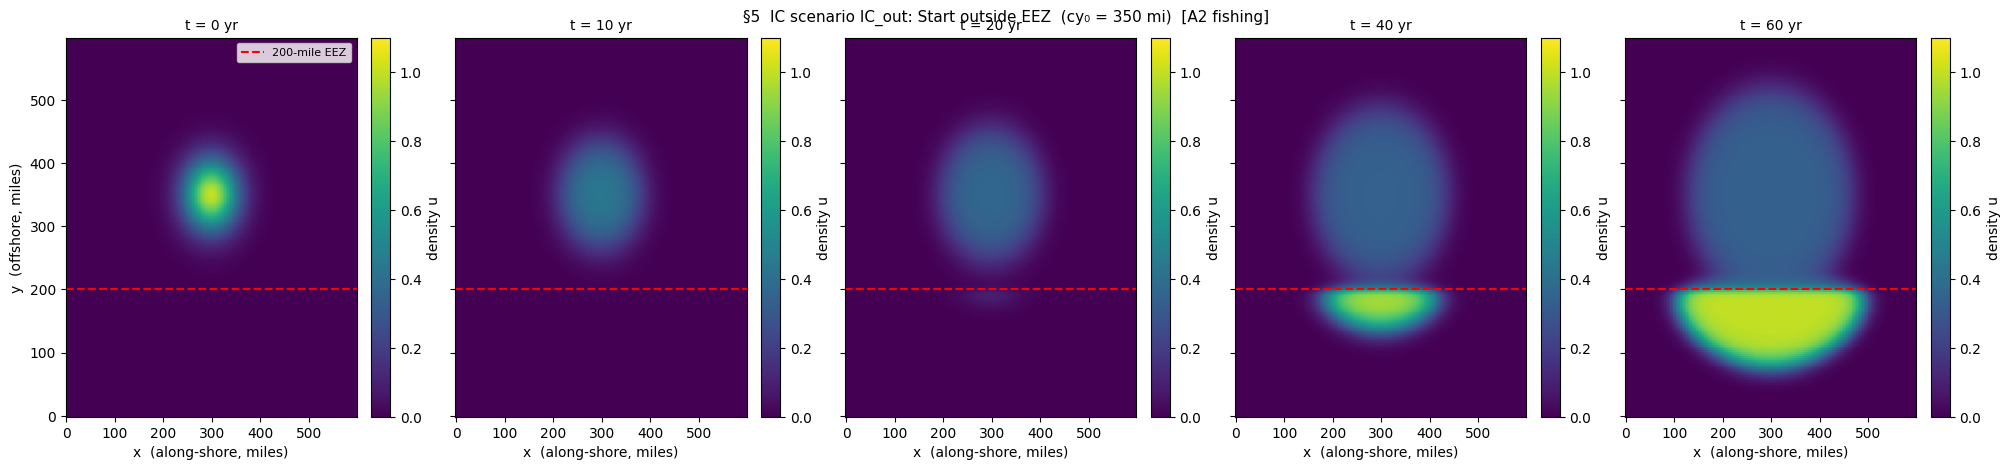

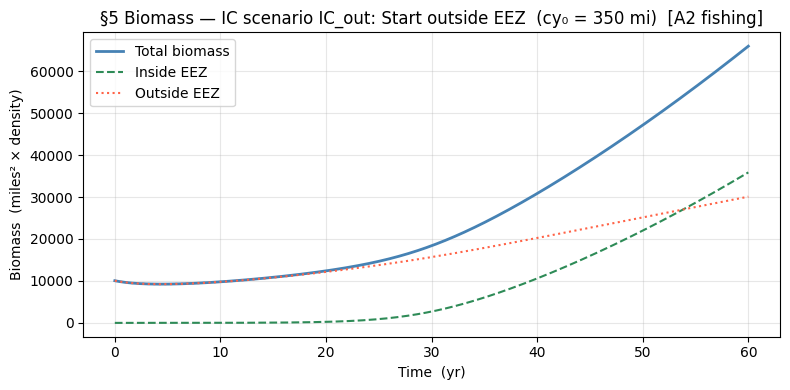

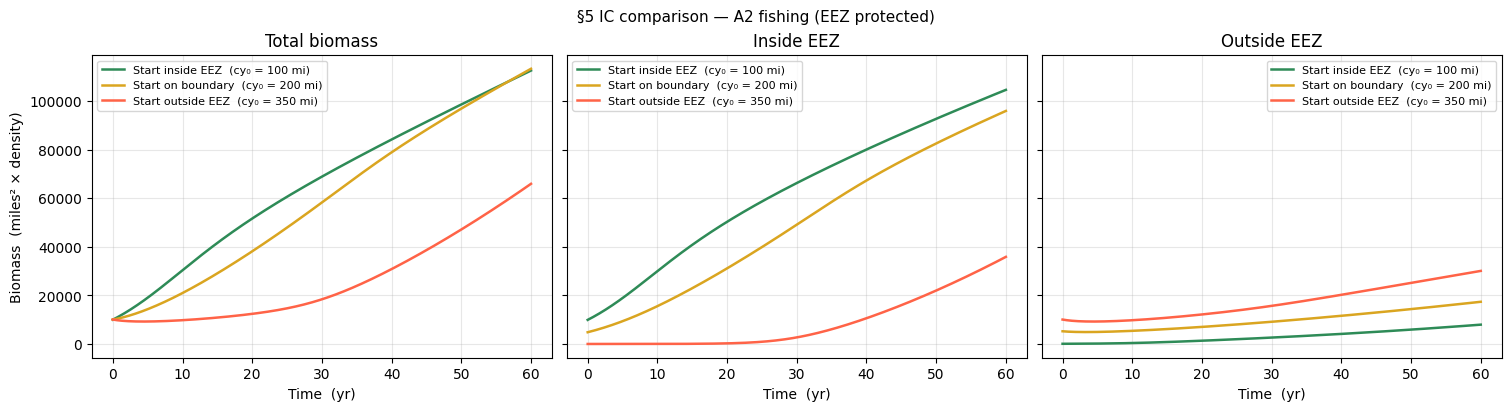

In [17]:
# ── §5 IC comparison: plot individual heatmaps + biomass, then combined ──

# Individual heatmaps + biomass for each IC scenario
for key, scen in IC_SCENARIOS_5.items():
    title = f'IC scenario {key}: {scen["label"]}  [A2 fishing]'
    plot_2d_snapshots_5(results_5_ic[key], title, K=K_5, y_boundary=Y_BND_5)
    plot_2d_biomass_5(results_5_ic[key], title)

# Combined biomass comparison across IC positions
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True, constrained_layout=True)
colours = {'IC_in': 'seagreen', 'IC_bnd': 'goldenrod', 'IC_out': 'tomato'}
for ax, qty, lbl in zip(axes, ['Btot', 'Bin', 'Bout'],
                         ['Total biomass', 'Inside EEZ', 'Outside EEZ']):
    for key, scen in IC_SCENARIOS_5.items():
        res = results_5_ic[key]
        ax.plot(res['time'], res[qty], lw=1.8,
                color=colours[key], label=scen['label'])
    ax.set_title(lbl)
    ax.set_xlabel('Time  (yr)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
axes[0].set_ylabel('Biomass  (miles² × density)')
fig.suptitle('§5 IC comparison — A2 fishing (EEZ protected)', fontsize=11)
plt.show()

# 6 — 2D Reaction–Diffusion: Competing Species (Lotka–Volterra)

We extend §5 to **two competing species** $(U, V)$ on the same 2D domain, with species-specific diffusivities and competition coefficients:

$$
\frac{\partial U}{\partial t} = r_1\,U\!\left(1 - \frac{U + a_{12}\,V}{K_1}\right)
  - h_1(y,t)\,U \;+\; D_1\,\nabla^2 U
$$

$$
\frac{\partial V}{\partial t} = r_2\,V\!\left(1 - \frac{V + a_{21}\,U}{K_2}\right)
  - h_2(y,t)\,V \;+\; D_2\,\nabla^2 V
$$

Same boundary conditions as §5. $\nabla^2$ uses `laplacian_2d_periodicx_neumanny` defined in §5.

**Dual stability constraint:**

$$
\Delta t = \min\!\left(\frac{0.2\,\min(\Delta x^2,\,\Delta y^2)}{4\max(D_1,D_2)},\;\; \frac{0.2}{\max(r_1, r_2)}\right)
$$

**Initial conditions:**  
- $U$: Gaussian centred near coast ($y \approx 0.15\,L_y$) — coastal species  
- $V$: Gaussian centred offshore ($y \approx 250$ miles) — offshore species  
- Both seeded with small noise for realism

---

### Scenarios

| Label | $a_{12}$ | $a_{21}$ | $D_1$ | $D_2$ | Description |
|-------|----------|----------|-------|-------|-------------|
| B0 | 0.6 | 0.7 | 10 | 10 | Coexistence (weak mutual competition) |
| B1 | 1.2 | 0.7 | 10 | 10 | Species 2 dominates ($a_{12} > 1$) |
| B2 | 0.6 | 0.6 | 5 | 25 | Movement asymmetry ($D_2 \gg D_1$) |

Outputs per scenario: **U heatmaps**, **V heatmaps**, **dominance map** $U/(U+V+\varepsilon)$, and a **biomass time series** panel.

In [18]:
import numpy as np
from matplotlib import pyplot as plt

# ═══════════════════════════════════════════════════════════════════════
# §6 SIMULATION FUNCTION
# Reuses laplacian_2d_periodicx_neumanny defined in §5 above.
# ═══════════════════════════════════════════════════════════════════════

def simulate_2d_two_species(
        r1, K1, D1, r2, K2, D2, a12, a21,
        h1_params, h2_params,
        nx, ny, dx, dy,
        T_end, snapshot_times, y_boundary, seed=42,
        cx_U0=None, cy_U0=None, cx_V0=None, cy_V0=None, sig_ic=40.0):
    """Explicit-Euler 2D two-species Lotka–Volterra + diffusion.

    PDEs:
        U_t = r1*U*(1-(U+a12*V)/K1) - h1(y)*U + D1*Lap(U)
        V_t = r2*V*(1-(V+a21*U)/K2) - h2(y)*V + D2*Lap(V)

    BCs: periodic in x (axis=1), Neumann no-flux in y (axis=0).
    Uses laplacian_2d_periodicx_neumanny from §5.

    Parameters
    ----------
    r1, K1, D1   : float  species-1 growth rate, capacity, diffusivity
    r2, K2, D2   : float  species-2 growth rate, capacity, diffusivity
    a12          : float  competition coefficient of V on U
    a21          : float  competition coefficient of U on V
    h1_params    : dict   {'h_in': float, 'h_out': float}  fishing on U
    h2_params    : dict   {'h_in': float, 'h_out': float}  fishing on V
    nx, ny       : int    grid dimensions
    dx, dy       : float  grid spacing (miles)
    T_end        : float  total simulation time
    snapshot_times : list times at which to save U and V
    y_boundary   : float  EEZ boundary (miles)
    seed         : int    random seed
    cx_U0, cy_U0 : float or None  centre of U initial blob (miles);
                                   both default to domain centre if None
    cx_V0, cy_V0 : float or None  centre of V initial blob (miles);
                                   both default to domain centre if None
    sig_ic       : float  standard deviation of initial Gaussians (miles)

    Returns
    -------
    dict with keys:
        'x_grid', 'y_grid'
        'snapshots_U', 'snapshots_V'  : dict {t -> ndarray (ny, nx)}
        'time', 'B1tot', 'B2tot'      : total biomass time series
        'B1in',  'B2in'               : biomass inside EEZ
        'B1out', 'B2out'              : biomass outside EEZ
        'y_bnd_row', 'dt'
    """
    np.random.seed(seed)

    # ── Grid ──────────────────────────────────────────────────────────
    x_grid = np.linspace(0.0, (nx - 1) * dx, nx)
    y_grid = np.linspace(0.0, (ny - 1) * dy, ny)
    XX, YY = np.meshgrid(x_grid, y_grid)           # both (ny, nx)
    Ly     = (ny - 1) * dy

    y_bnd_row = int(np.searchsorted(y_grid, y_boundary, side='right')) - 1

    # ── Time step: diffusion CFL and reaction constraint ───────────────
    dt_diff = 0.2 * min(dx**2, dy**2) / (4.0 * max(D1, D2))
    dt_rxn  = 0.2 / max(r1, r2)
    dt      = min(dt_diff, dt_rxn)
    nt      = int(np.ceil(T_end / dt))
    dt      = T_end / nt

    # ── Initial conditions ─────────────────────────────────────────────
    # Both species default to domain centre — competition unfolds from
    # the same starting location, driven by diffusion and competition.
    _cx_U = cx_U0 if cx_U0 is not None else 0.5 * (nx - 1) * dx
    _cy_U = cy_U0 if cy_U0 is not None else 0.5 * Ly
    U = 0.8 * K1 * np.exp(-((XX - _cx_U)**2 + (YY - _cy_U)**2) / (2.0 * sig_ic**2))

    _cx_V = cx_V0 if cx_V0 is not None else 0.5 * (nx - 1) * dx
    _cy_V = cy_V0 if cy_V0 is not None else 0.5 * Ly
    V = 0.8 * K2 * np.exp(-((XX - _cx_V)**2 + (YY - _cy_V)**2) / (2.0 * sig_ic**2))

    U = np.maximum(U, 0.0)
    V = np.maximum(V, 0.0)

    # ── Pre-build fishing arrays (constant in time for §6) ────────────
    # Shape (ny,1) so they broadcast over (ny,nx)
    h1_y = np.where(y_grid <= y_boundary,
                    h1_params['h_in'], h1_params['h_out'])[:, np.newaxis]
    h2_y = np.where(y_grid <= y_boundary,
                    h2_params['h_in'], h2_params['h_out'])[:, np.newaxis]

    # ── Snapshot setup ────────────────────────────────────────────────
    snap_set = sorted(snapshot_times)
    snap_idx = 0
    snapshots_U, snapshots_V = {}, {}
    if snap_idx < len(snap_set) and snap_set[snap_idx] <= 0.0 + 1e-12:
        snapshots_U[snap_set[snap_idx]] = U.copy()
        snapshots_V[snap_set[snap_idx]] = V.copy()
        snap_idx += 1

    # ── Biomass diagnostics ───────────────────────────────────────────
    def _btot(F, y_vals=None):
        y_use = y_grid if y_vals is None else y_vals
        return np.trapezoid(np.trapezoid(F, x_grid, axis=1), y_use)

    time_arr = np.empty(nt + 1)
    B1tot = np.empty(nt + 1);  B2tot = np.empty(nt + 1)
    B1in  = np.empty(nt + 1);  B2in  = np.empty(nt + 1)
    B1out = np.empty(nt + 1);  B2out = np.empty(nt + 1)

    time_arr[0] = 0.0
    B1tot[0] = _btot(U);  B2tot[0] = _btot(V)
    B1in[0]  = _btot(U[:y_bnd_row + 1, :], y_grid[:y_bnd_row + 1])
    B2in[0]  = _btot(V[:y_bnd_row + 1, :], y_grid[:y_bnd_row + 1])
    B1out[0] = _btot(U[y_bnd_row:, :], y_grid[y_bnd_row:])
    B2out[0] = _btot(V[y_bnd_row:, :], y_grid[y_bnd_row:])

    _warned = False

    # ── Time loop ─────────────────────────────────────────────────────
    for n in range(1, nt + 1):
        t_now = n * dt

        lapU = laplacian_2d_periodicx_neumanny(U, dx, dy)
        lapV = laplacian_2d_periodicx_neumanny(V, dx, dy)

        dU = r1 * U * (1.0 - (U + a12 * V) / K1) - h1_y * U + D1 * lapU
        dV = r2 * V * (1.0 - (V + a21 * U) / K2) - h2_y * V + D2 * lapV

        U = U + dt * dU
        V = V + dt * dV

        # Clip negatives (cross-competition can briefly push values negative)
        if (U.min() < -1e-10 or V.min() < -1e-10) and not _warned:
            print(f'  NOTE: negative values at t={t_now:.3f} yr '
                  f'(min U={U.min():.2e}, min V={V.min():.2e}) — clipping')
            _warned = True
        U = np.maximum(U, 0.0)
        V = np.maximum(V, 0.0)

        time_arr[n] = t_now
        B1tot[n] = _btot(U);  B2tot[n] = _btot(V)
        B1in[n]  = _btot(U[:y_bnd_row + 1, :], y_grid[:y_bnd_row + 1])
        B2in[n]  = _btot(V[:y_bnd_row + 1, :], y_grid[:y_bnd_row + 1])
        B1out[n] = _btot(U[y_bnd_row:, :], y_grid[y_bnd_row:])
        B2out[n] = _btot(V[y_bnd_row:, :], y_grid[y_bnd_row:])

        while snap_idx < len(snap_set) and t_now >= snap_set[snap_idx] - 0.5 * dt:
            snapshots_U[snap_set[snap_idx]] = U.copy()
            snapshots_V[snap_set[snap_idx]] = V.copy()
            snap_idx += 1

    return {
        'x_grid': x_grid, 'y_grid': y_grid,
        'snapshots_U': snapshots_U, 'snapshots_V': snapshots_V,
        'time': time_arr,
        'B1tot': B1tot, 'B2tot': B2tot,
        'B1in': B1in,   'B2in': B2in,
        'B1out': B1out,  'B2out': B2out,
        'y_bnd_row': y_bnd_row, 'dt': dt,
    }


print('§6 function defined: simulate_2d_two_species')

§6 function defined: simulate_2d_two_species


In [19]:
# ── §6 Grid & species parameters ──────────────────────────────────────
# Same grid as §5
nx_6: int   = 200;   ny_6: int   = 200
dx_6: float = 3.0;   dy_6: float = 3.0
T_end_6: float = 60.0
Y_BND_6: float = 200.0
SNAP_TIMES_6 = [0.0, 10.0, 20.0, 40.0, 60.0]

# ── Species parameters ────────────────────────────────────────────────
r1_6:  float = 0.3;   K1_6: float = 1.0   # species 1 (coastal)
r2_6:  float = 0.25;  K2_6: float = 1.0   # species 2 (offshore)

# ── Fishing (light, species-specific) ────────────────────────────────
H1_6 = dict(h_in=0.05, h_out=0.12)   # harvest on species 1
H2_6 = dict(h_in=0.05, h_out=0.12)   # harvest on species 2

# ── Scenario definitions ──────────────────────────────────────────────
SCENARIOS_6 = {
    'B0': dict(
        label = 'Coexistence  (a12=0.6, a21=0.7, D1=D2=10)',
        a12   = 0.6,
        a21   = 0.7,
        D1    = 10.0,
        D2    = 10.0,
    ),
    'B1': dict(
        label = 'Species 2 dominates  (a12=1.2, a21=0.7, D1=D2=10)',
        a12   = 1.2,
        a21   = 0.7,
        D1    = 10.0,
        D2    = 10.0,
    ),
    'B2': dict(
        label = 'Movement asymmetry  (a12=a21=0.6, D1=5, D2=25)',
        a12   = 0.6,
        a21   = 0.6,
        D1    = 5.0,
        D2    = 25.0,
    ),
}

# ── Stability printout ────────────────────────────────────────────────
for key, scen in SCENARIOS_6.items():
    dt_diff = 0.2 * min(dx_6**2, dy_6**2) / (4.0 * max(scen['D1'], scen['D2']))
    dt_rxn  = 0.2 / max(r1_6, r2_6)
    dt_use  = min(dt_diff, dt_rxn)
    nt_est  = int(np.ceil(T_end_6 / dt_use))
    print(f'{key}: dt_diff={dt_diff:.4f}, dt_rxn={dt_rxn:.4f}'
          f'  -> dt={dt_use:.4f} yr  (~{nt_est} steps)')

print(f'\nScenarios defined: {list(SCENARIOS_6.keys())}')

B0: dt_diff=0.0450, dt_rxn=0.6667  -> dt=0.0450 yr  (~1334 steps)
B1: dt_diff=0.0450, dt_rxn=0.6667  -> dt=0.0450 yr  (~1334 steps)
B2: dt_diff=0.0180, dt_rxn=0.6667  -> dt=0.0180 yr  (~3334 steps)

Scenarios defined: ['B0', 'B1', 'B2']


In [20]:
# ── §6 Run all scenarios ──────────────────────────────────────────────
results_6 = {}
for key, scen in SCENARIOS_6.items():
    print(f'Running §6 scenario {key}: {scen["label"]} ...', end='  ', flush=True)
    res = simulate_2d_two_species(
        r1             = r1_6,
        K1             = K1_6,
        D1             = scen['D1'],
        r2             = r2_6,
        K2             = K2_6,
        D2             = scen['D2'],
        a12            = scen['a12'],
        a21            = scen['a21'],
        h1_params      = H1_6,
        h2_params      = H2_6,
        nx             = nx_6,
        ny             = ny_6,
        dx             = dx_6,
        dy             = dy_6,
        T_end          = T_end_6,
        snapshot_times = SNAP_TIMES_6,
        y_boundary     = Y_BND_6,
        seed           = 42,
    )
    results_6[key] = res
    print(f'done.  dt={res["dt"]:.5f} yr,  '
          f'B1tot(final)={res["B1tot"][-1]:.3f},  '
          f'B2tot(final)={res["B2tot"][-1]:.3f}')

Running §6 scenario B0: Coexistence  (a12=0.6, a21=0.7, D1=D2=10) ...  done.  dt=0.04498 yr,  B1tot(final)=113519.443,  B2tot(final)=28958.902
Running §6 scenario B1: Species 2 dominates  (a12=1.2, a21=0.7, D1=D2=10) ...  done.  dt=0.04498 yr,  B1tot(final)=84159.954,  B2tot(final)=43366.482
Running §6 scenario B2: Movement asymmetry  (a12=a21=0.6, D1=5, D2=25) ...  done.  dt=0.01800 yr,  B1tot(final)=70643.406,  B2tot(final)=87205.422


§6 plot helpers defined: plot_2d_two_species, plot_2d_biomass_6


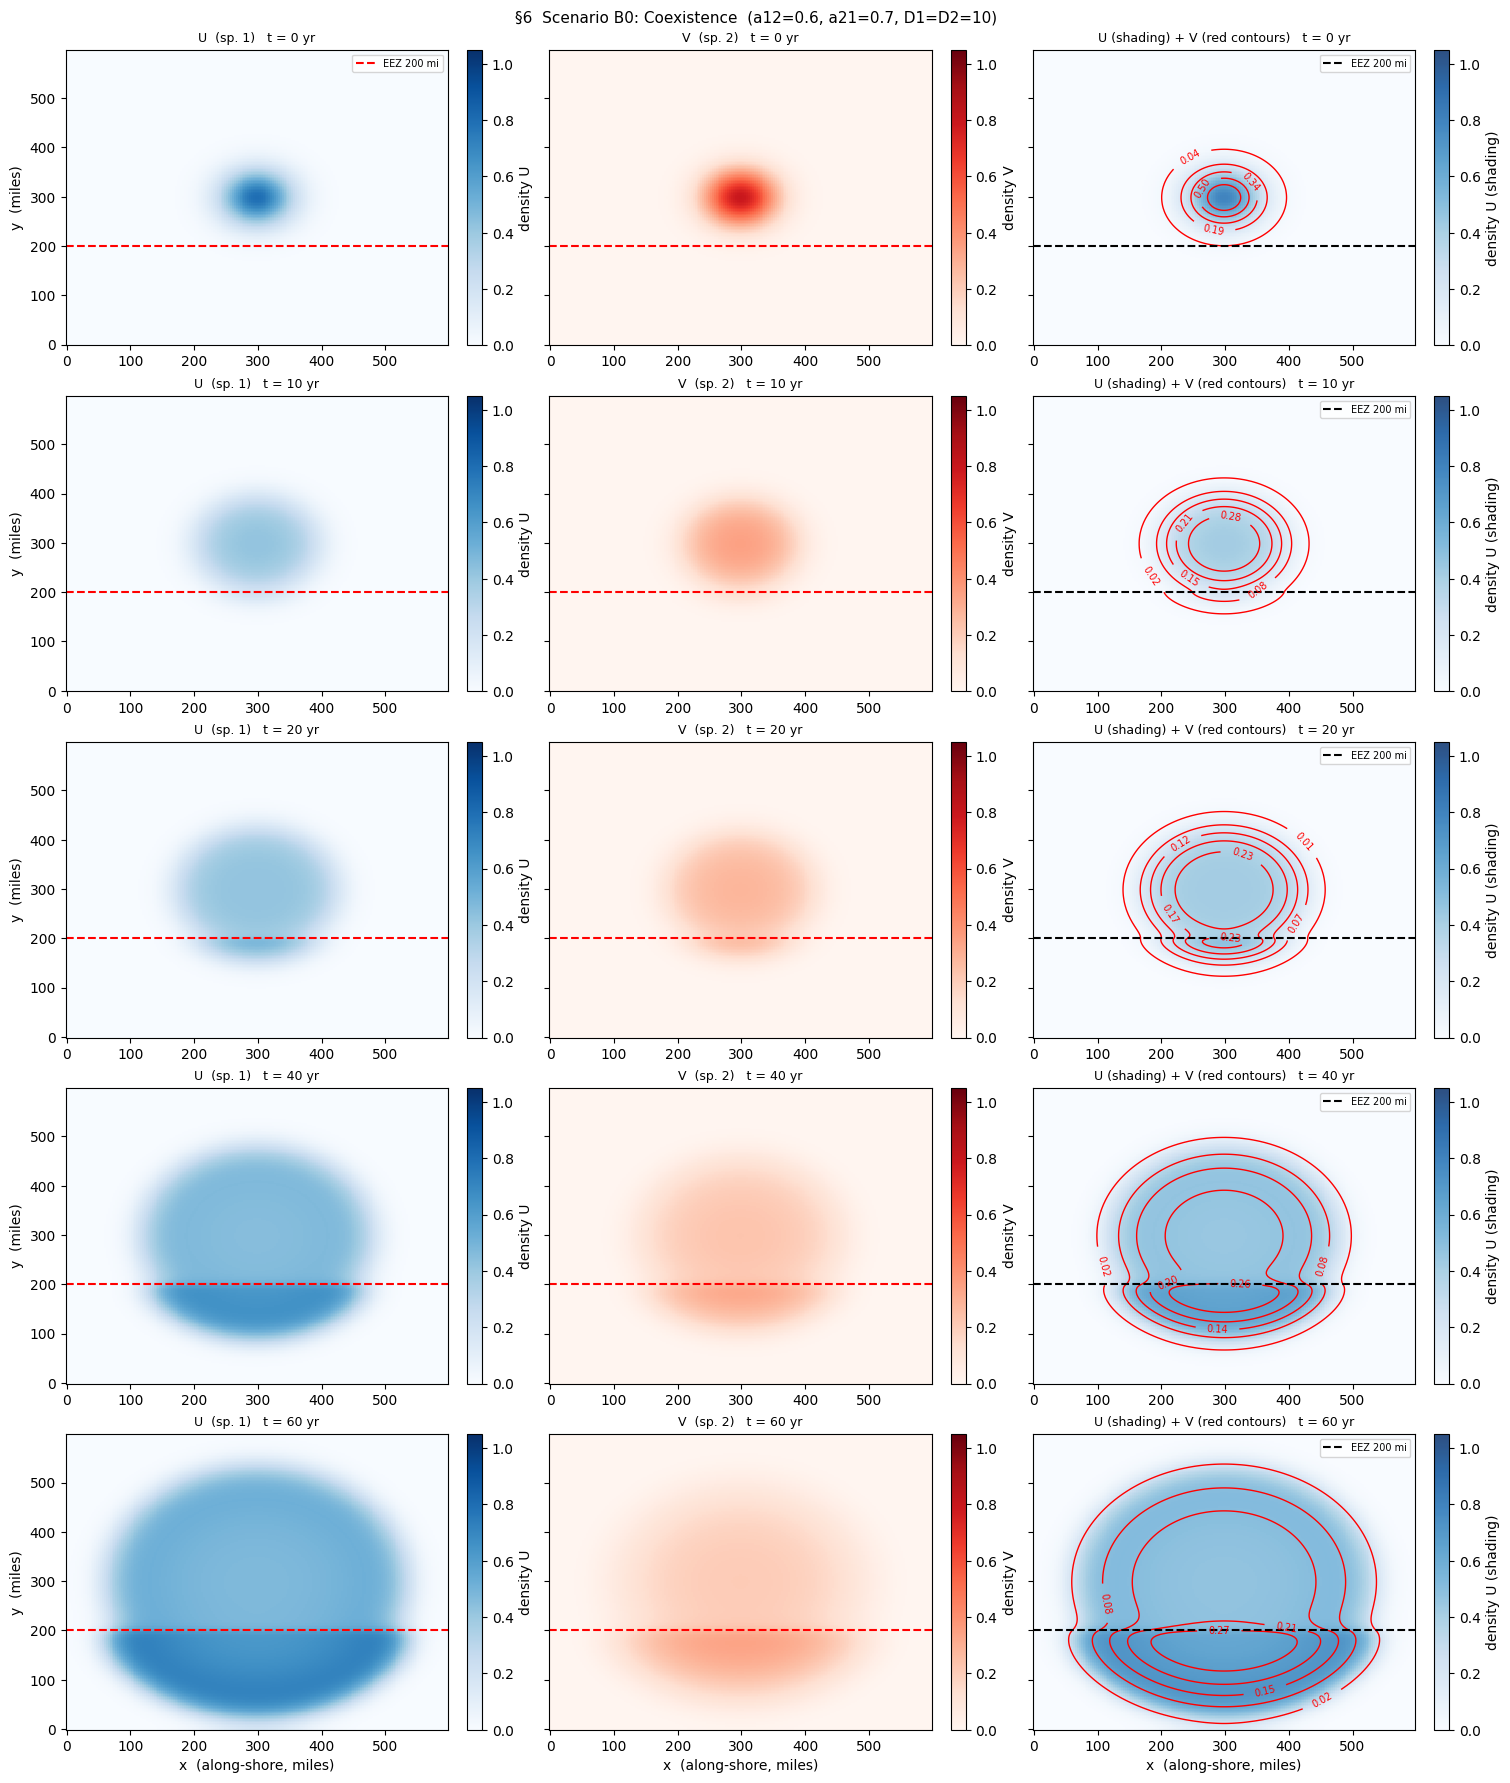

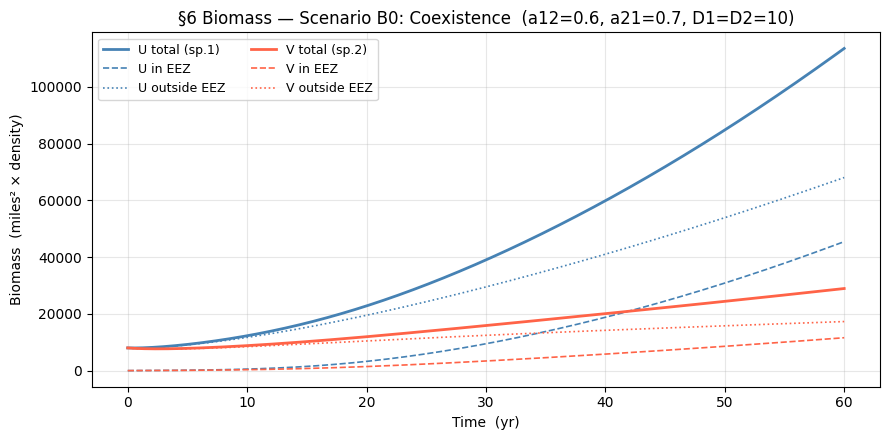

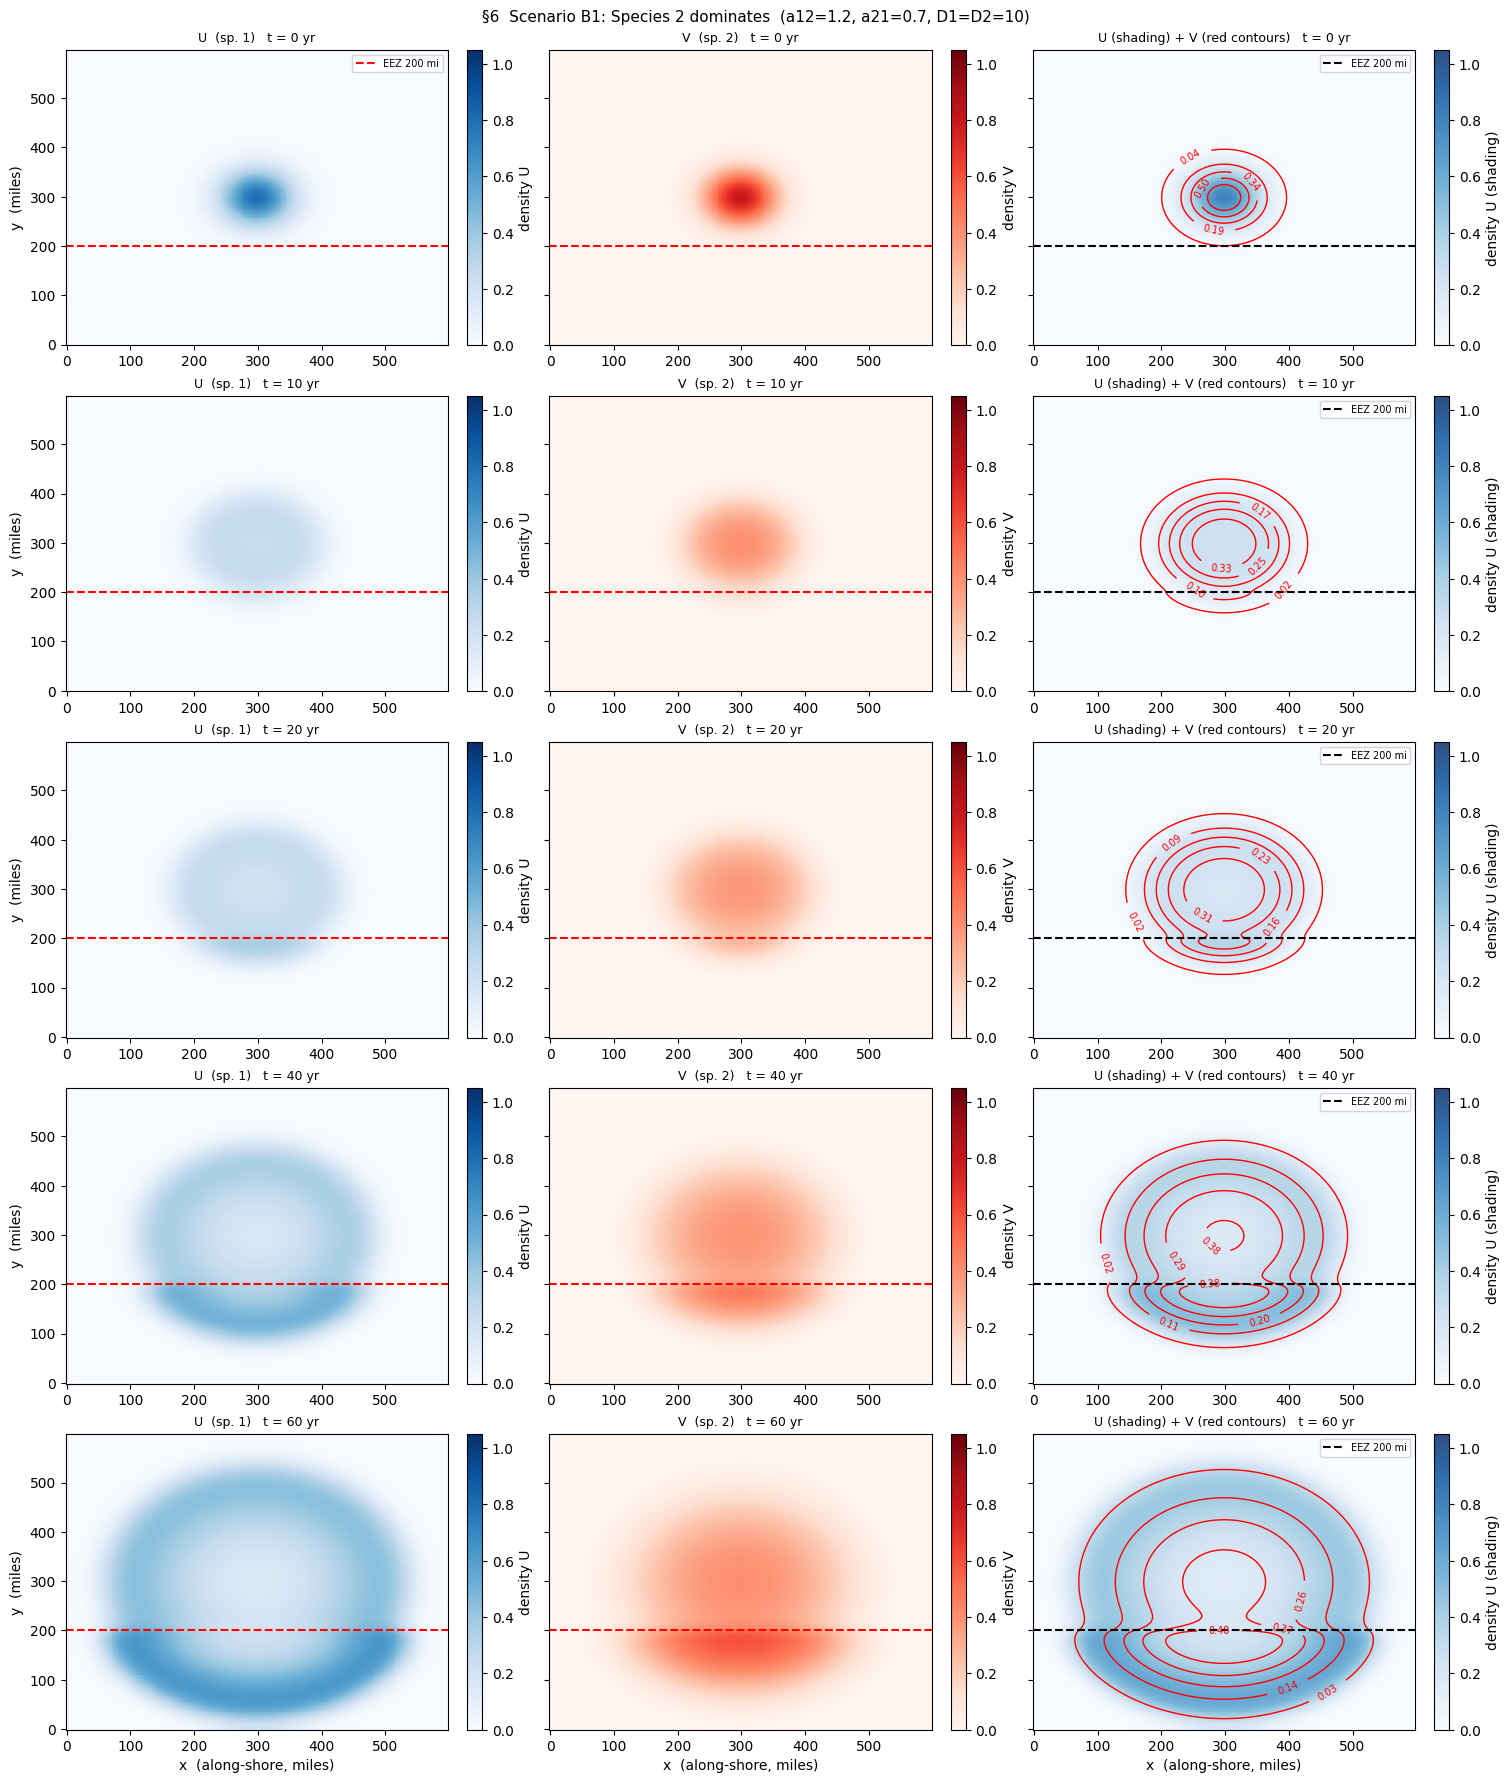

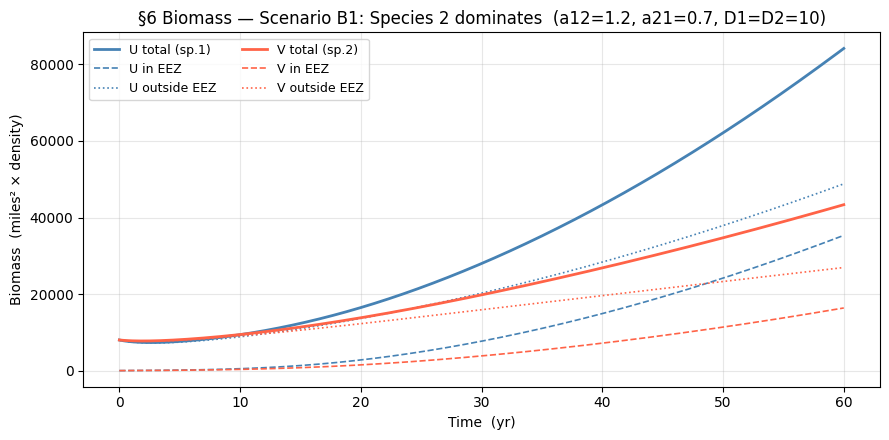

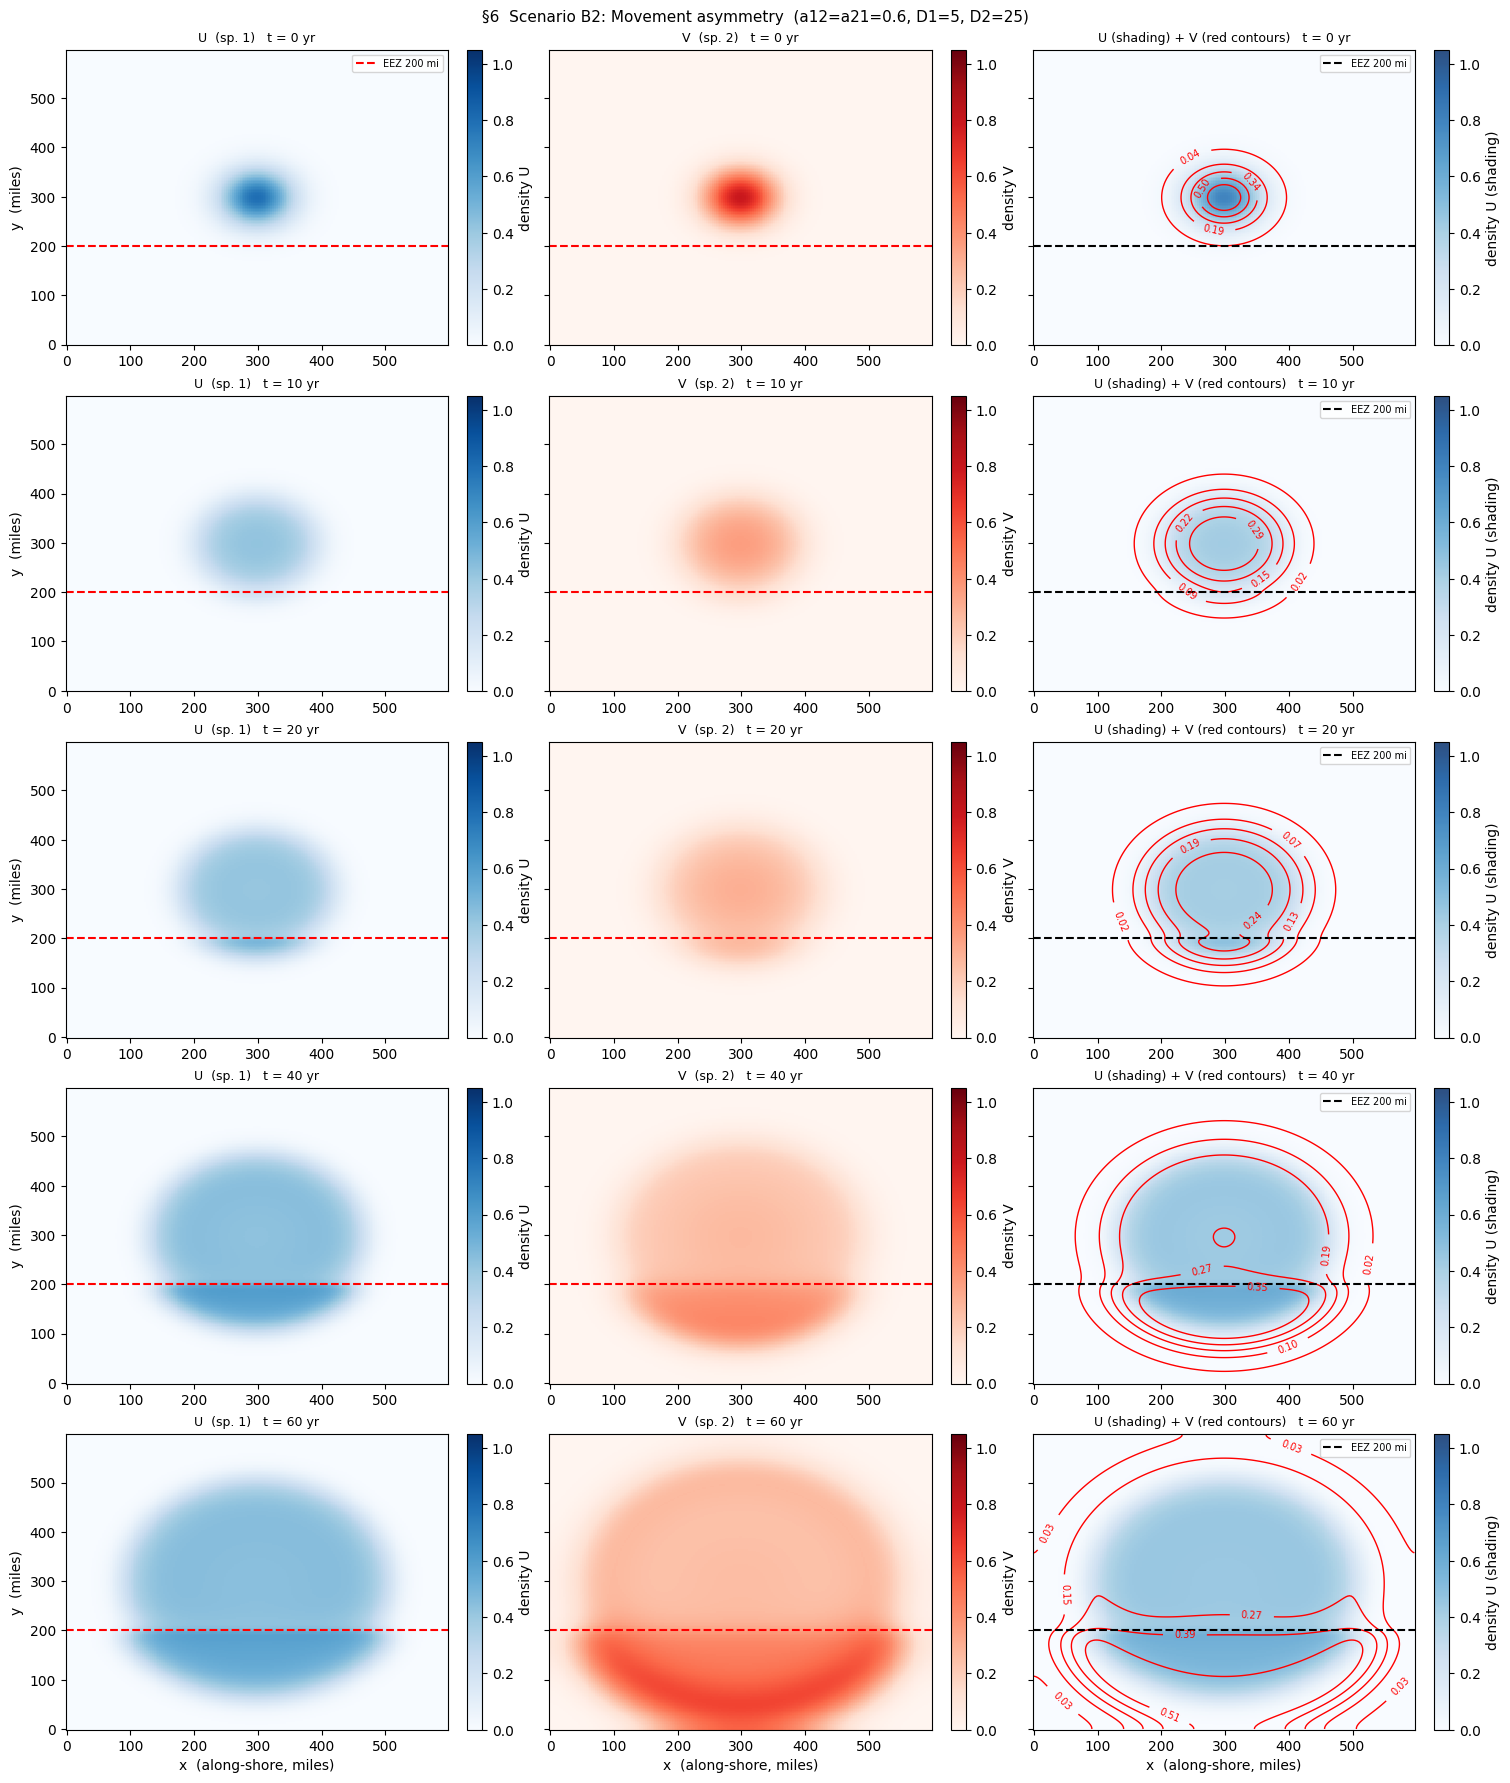

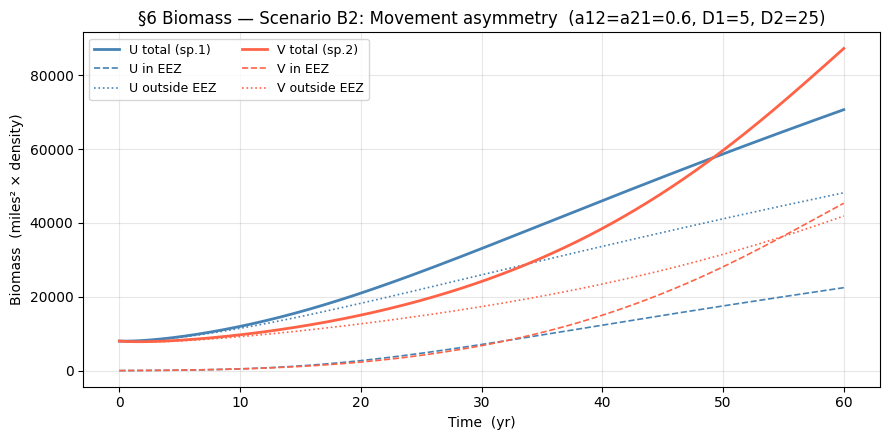

In [21]:
# ═══════════════════════════════════════════════════════════════════════
# §6 PLOTTING HELPERS
# ═══════════════════════════════════════════════════════════════════════

def plot_2d_two_species(res, title, K1, K2, y_boundary):
    """For each snapshot: three side-by-side panels — U, V, U+V overlay.

    Row layout: one row per snapshot time.
    Panel 1: U density heatmap (Blues).
    Panel 2: V density heatmap (Reds).
    Panel 3: U heatmap (Blues) with V contour lines (red) overlaid —
             shows where species overlap and compete spatially.
    """
    snap_times_sorted = sorted(res['snapshots_U'].keys())
    n_snaps = len(snap_times_sorted)
    x_grid  = res['x_grid']
    y_grid  = res['y_grid']

    fig, axes = plt.subplots(n_snaps, 3,
                              figsize=(15, 3.5 * n_snaps),
                              constrained_layout=True)
    # Ensure axes is always 2D
    if n_snaps == 1:
        axes = axes[np.newaxis, :]

    for row, ts in enumerate(snap_times_sorted):
        U   = res['snapshots_U'][ts]
        V   = res['snapshots_V'][ts]
        # ── U panel ───────────────────────────────────────────────
        ax = axes[row, 0]
        pcm = ax.pcolormesh(x_grid, y_grid, U,
                            cmap='Blues', vmin=0.0, vmax=K1 * 1.05,
                            shading='auto')
        ax.axhline(y_boundary, color='red', ls='--', lw=1.5, label='EEZ 200 mi')
        ax.set_title(f'U  (sp. 1)   t = {ts:g} yr', fontsize=9)
        ax.set_ylabel('y  (miles)')
        if row == 0:
            ax.legend(fontsize=7, loc='upper right')
        fig.colorbar(pcm, ax=ax, label='density U')

        # ── V panel ───────────────────────────────────────────────
        ax = axes[row, 1]
        pcm = ax.pcolormesh(x_grid, y_grid, V,
                            cmap='Reds', vmin=0.0, vmax=K2 * 1.05,
                            shading='auto')
        ax.axhline(y_boundary, color='red', ls='--', lw=1.5)
        ax.set_title(f'V  (sp. 2)   t = {ts:g} yr', fontsize=9)
        ax.set_yticklabels([])
        fig.colorbar(pcm, ax=ax, label='density V')

        # ── Dominance map ─────────────────────────────────────────
        ax = axes[row, 2]
        pcm = ax.pcolormesh(x_grid, y_grid, U,
                            cmap='Blues', vmin=0.0, vmax=K1 * 1.05,
                            shading='auto', alpha=0.85)
        fig.colorbar(pcm, ax=ax, label='density U (shading)')
        vmax_v = V.max() if V.max() > 1e-6 else 1.0
        levels_v = np.linspace(0.05 * vmax_v, vmax_v, 6)
        cs = ax.contour(x_grid, y_grid, V,
                        levels=levels_v, colors='red', linewidths=1.0)
        ax.clabel(cs, inline=True, fontsize=7, fmt='%.2f')
        ax.axhline(y_boundary, color='black', ls='--', lw=1.5, label='EEZ 200 mi')
        ax.set_title(f'U (shading) + V (red contours)   t = {ts:g} yr', fontsize=9)
        ax.set_yticklabels([])
        ax.legend(fontsize=7, loc='upper right')

    for col in range(3):
        axes[-1, col].set_xlabel('x  (along-shore, miles)')

    fig.suptitle(f'§6  {title}', fontsize=11, y=1.01)
    plt.show()


def plot_2d_biomass_6(res, title):
    """Biomass time series for §6: both species, total and EEZ-split."""
    fig, ax = plt.subplots(figsize=(9, 4.5))
    # Species 1
    ax.plot(res['time'], res['B1tot'], color='steelblue', lw=2.0,
            label='U total (sp.1)')
    ax.plot(res['time'], res['B1in'],  color='steelblue', lw=1.2, ls='--',
            label='U in EEZ')
    ax.plot(res['time'], res['B1out'], color='steelblue', lw=1.2, ls=':',
            label='U outside EEZ')
    # Species 2
    ax.plot(res['time'], res['B2tot'], color='tomato', lw=2.0,
            label='V total (sp.2)')
    ax.plot(res['time'], res['B2in'],  color='tomato', lw=1.2, ls='--',
            label='V in EEZ')
    ax.plot(res['time'], res['B2out'], color='tomato', lw=1.2, ls=':',
            label='V outside EEZ')
    ax.set_xlabel('Time  (yr)')
    ax.set_ylabel('Biomass  (miles² × density)')
    ax.set_title(f'§6 Biomass — {title}')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=2)
    fig.tight_layout()
    plt.show()


print('§6 plot helpers defined: plot_2d_two_species, plot_2d_biomass_6')

# ── §6 Plot all scenarios ─────────────────────────────────────────────
for key, scen in SCENARIOS_6.items():
    res   = results_6[key]
    title = f'Scenario {key}: {scen["label"]}'
    plot_2d_two_species(res, title, K1=K1_6, K2=K2_6, y_boundary=Y_BND_6)
    plot_2d_biomass_6(res, title)